In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.gif')]

In [4]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    print ("Maximum difference was %d" % (max_diff))
    
    return ela_im

In [5]:
fakes_datasets_filename = get_imlist('datasets/train/fake/')
reals_datasets_filename = get_imlist('datasets/train/real/')

# Starts Here

In [6]:
fake_imfile_list = []
for filename in fakes_datasets_filename[0:750]:
    fake_imfile_list.append(array(convert_to_ela_image(filename, 90).resize((128, 128))).flatten())

Maximum difference was 9
Maximum difference was 42
Maximum difference was 30
Maximum difference was 12
Maximum difference was 22
Maximum difference was 6
Maximum difference was 28
Maximum difference was 30
Maximum difference was 51
Maximum difference was 57
Maximum difference was 27
Maximum difference was 36
Maximum difference was 4
Maximum difference was 16
Maximum difference was 25
Maximum difference was 6
Maximum difference was 131
Maximum difference was 43
Maximum difference was 7
Maximum difference was 41
Maximum difference was 45
Maximum difference was 21
Maximum difference was 7
Maximum difference was 3
Maximum difference was 7
Maximum difference was 71
Maximum difference was 30
Maximum difference was 2
Maximum difference was 26
Maximum difference was 33
Maximum difference was 16
Maximum difference was 9
Maximum difference was 6
Maximum difference was 44
Maximum difference was 6
Maximum difference was 87
Maximum difference was 21
Maximum difference was 30
Maximum difference was 

Maximum difference was 38
Maximum difference was 29
Maximum difference was 36
Maximum difference was 36
Maximum difference was 40
Maximum difference was 2
Maximum difference was 46
Maximum difference was 30
Maximum difference was 7
Maximum difference was 31
Maximum difference was 37
Maximum difference was 3
Maximum difference was 1
Maximum difference was 1
Maximum difference was 23
Maximum difference was 1
Maximum difference was 3
Maximum difference was 16
Maximum difference was 5
Maximum difference was 4
Maximum difference was 42
Maximum difference was 41
Maximum difference was 17
Maximum difference was 21
Maximum difference was 25
Maximum difference was 4
Maximum difference was 17
Maximum difference was 4
Maximum difference was 34
Maximum difference was 33
Maximum difference was 2
Maximum difference was 21
Maximum difference was 19
Maximum difference was 2
Maximum difference was 41
Maximum difference was 27
Maximum difference was 24
Maximum difference was 26
Maximum difference was 37

Maximum difference was 6
Maximum difference was 62
Maximum difference was 13
Maximum difference was 33
Maximum difference was 22
Maximum difference was 75
Maximum difference was 80
Maximum difference was 29
Maximum difference was 18
Maximum difference was 20
Maximum difference was 18
Maximum difference was 6
Maximum difference was 39
Maximum difference was 31
Maximum difference was 27
Maximum difference was 4
Maximum difference was 46
Maximum difference was 7
Maximum difference was 70
Maximum difference was 3
Maximum difference was 27
Maximum difference was 1
Maximum difference was 3
Maximum difference was 2
Maximum difference was 7
Maximum difference was 2
Maximum difference was 14
Maximum difference was 4
Maximum difference was 3
Maximum difference was 24
Maximum difference was 46
Maximum difference was 20
Maximum difference was 17
Maximum difference was 3
Maximum difference was 22
Maximum difference was 5
Maximum difference was 16
Maximum difference was 31
Maximum difference was 47


In [7]:
real_imfile_list = []
for filename in reals_datasets_filename[0:750]:
    real_imfile_list.append(array(convert_to_ela_image(filename, 90).resize((128, 128))).flatten())

Maximum difference was 3
Maximum difference was 3
Maximum difference was 11
Maximum difference was 4
Maximum difference was 18
Maximum difference was 16
Maximum difference was 18
Maximum difference was 16
Maximum difference was 19
Maximum difference was 14
Maximum difference was 8
Maximum difference was 8
Maximum difference was 11
Maximum difference was 13
Maximum difference was 1
Maximum difference was 6
Maximum difference was 29
Maximum difference was 4
Maximum difference was 12
Maximum difference was 15
Maximum difference was 54
Maximum difference was 51
Maximum difference was 12
Maximum difference was 2
Maximum difference was 15
Maximum difference was 15
Maximum difference was 17
Maximum difference was 6
Maximum difference was 3
Maximum difference was 16
Maximum difference was 2
Maximum difference was 11
Maximum difference was 14
Maximum difference was 7
Maximum difference was 16
Maximum difference was 6
Maximum difference was 15
Maximum difference was 21
Maximum difference was 4
M

Maximum difference was 3
Maximum difference was 5
Maximum difference was 5
Maximum difference was 19
Maximum difference was 1
Maximum difference was 10
Maximum difference was 3
Maximum difference was 3
Maximum difference was 13
Maximum difference was 12
Maximum difference was 5
Maximum difference was 11
Maximum difference was 7
Maximum difference was 7
Maximum difference was 5
Maximum difference was 5
Maximum difference was 18
Maximum difference was 16
Maximum difference was 4
Maximum difference was 9
Maximum difference was 19
Maximum difference was 2
Maximum difference was 11
Maximum difference was 16
Maximum difference was 17
Maximum difference was 4
Maximum difference was 30
Maximum difference was 16
Maximum difference was 6
Maximum difference was 12
Maximum difference was 13
Maximum difference was 3
Maximum difference was 21
Maximum difference was 5
Maximum difference was 15
Maximum difference was 12
Maximum difference was 7
Maximum difference was 16
Maximum difference was 9
Maximu

Maximum difference was 16
Maximum difference was 20
Maximum difference was 5
Maximum difference was 15
Maximum difference was 2
Maximum difference was 3
Maximum difference was 1
Maximum difference was 5
Maximum difference was 3
Maximum difference was 18
Maximum difference was 16
Maximum difference was 25
Maximum difference was 20
Maximum difference was 15
Maximum difference was 3
Maximum difference was 17
Maximum difference was 4
Maximum difference was 60
Maximum difference was 4
Maximum difference was 3
Maximum difference was 5
Maximum difference was 17
Maximum difference was 7
Maximum difference was 6
Maximum difference was 17
Maximum difference was 3
Maximum difference was 21
Maximum difference was 22
Maximum difference was 2
Maximum difference was 16
Maximum difference was 3
Maximum difference was 19
Maximum difference was 12
Maximum difference was 12
Maximum difference was 7
Maximum difference was 8
Maximum difference was 2
Maximum difference was 6
Maximum difference was 22
Maximu

In [8]:
len(fake_imfile_list)

750

In [9]:
len(real_imfile_list)

750

# Lanjut

In [10]:
for index, fake_imfile in enumerate(fake_imfile_list):
    fake_imfile_list[index] = array(fake_imfile) / 255.0

In [11]:
for index, real_imfile in enumerate(real_imfile_list):
    real_imfile_list[index] = array(real_imfile) / 255.0

# Change to Data Frame

## Extend and Delete

In [12]:
X = []
X.extend(fake_imfile_list)
X.extend(real_imfile_list)

In [13]:
len(X)

1500

In [14]:
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.109804,0.109804,0.000000,0.109804,0.000000,0.219608,0.219608,0.109804,0.000000,0.000000,...,0.109804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109804,0.109804,0.000000
1,0.023529,0.023529,0.047059,0.023529,0.023529,0.047059,0.023529,0.023529,0.047059,0.000000,...,0.023529,0.047059,0.047059,0.047059,0.047059,0.047059,0.047059,0.047059,0.047059,0.047059
2,0.031373,0.031373,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.066667,...,0.000000,0.031373,0.031373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.164706,0.247059,0.082353,0.082353,0.164706,0.000000,0.164706,0.164706,0.000000,0.000000,...,0.082353,0.082353,0.082353,0.082353,0.082353,0.082353,0.082353,0.082353,0.082353,0.082353
4,0.133333,0.133333,0.133333,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137,...,0.133333,0.090196,0.000000,0.133333,0.043137,0.043137,0.043137,0.043137,0.043137,0.043137
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.031373,0.031373,0.000000,0.000000,0.000000,0.031373,...,0.066667,0.000000,0.000000,0.066667,0.066667,0.098039,0.031373,0.031373,0.031373,0.031373
8,0.000000,0.000000,0.019608,0.039216,0.000000,0.039216,0.000000,0.000000,0.000000,0.019608,...,0.019608,0.019608,0.019608,0.019608,0.000000,0.019608,0.039216,0.019608,0.019608,0.019608
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.015686,0.031373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Add Y

In [15]:
Y = []
for i in range(len(fake_imfile_list)):
    Y.append(1)
for i in range(len(real_imfile_list)):
    Y.append(0)

In [16]:
Y = to_categorical(Y, num_classes=2)

In [17]:
Y.shape

(1500, 2)

# Reshape X

In [18]:
X = X.values.reshape(-1, 128, 128, 3)

In [19]:
X.shape

(1500, 128, 128, 3)

## Train Test Split

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=5)

In [21]:
X_val

array([[[[0.04313725, 0.01960784, 0.        ],
         [0.        , 0.        , 0.04313725],
         [0.01960784, 0.01960784, 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.04313725],
         [0.        , 0.        , 0.04313725],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.04313725, 0.04313725, 0.08627451],
         [0.04313725, 0.01960784, 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.01960784, 0.01960784, 0.01960784]],

        ...,

        [[0.01960784, 0.01960784, 0.        ],
         [0.        , 0.        , 0.01960784]

# Model

In [22]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [23]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [24]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [26]:
epochs = 50
batch_size = 100

In [27]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Train on 1350 samples, validate on 150 samples
Epoch 1/50
 - 21s - loss: 1.1957 - acc: 0.5230 - val_loss: 0.6975 - val_acc: 0.4867
Epoch 2/50
 - 4s - loss: 0.6807 - acc: 0.5400 - val_loss: 1.8829 - val_acc: 0.5133
Epoch 3/50
 - 3s - loss: 0.7634 - acc: 0.6044 - val_loss: 0.6371 - val_acc: 0.7667
Epoch 4/50
 - 4s - loss: 0.5649 - acc: 0.7526 - val_loss: 1.0749 - val_acc: 0.5267
Epoch 5/50
 - 3s - loss: 0.7123 - acc: 0.7400 - val_loss: 0.5658 - val_acc: 0.7533
Epoch 6/50
 - 3s - loss: 0.5759 - acc: 0.8067 - val_loss: 0.5585 - val_acc: 0.7733
Epoch 7/50
 - 3s - loss: 0.4001 - acc: 0.8541 - val_loss: 0.7361 - val_acc: 0.5800
Epoch 8/50
 - 3s - loss: 0.4018 - acc: 0.8363 - val_loss: 0.6102 - val_acc: 0.7467
Epoch 9/50
 - 3s - loss: 0.3472 - acc: 0.8948 - val_loss: 0.6758 - val_acc: 0.7333
Epoch 10/50
 - 3s - loss: 0.2597 - acc: 0.8889 - val_loss: 0.6827 - val_acc: 0.8200
Epoch 11/50
 - 3s - loss: 0.3271 - acc: 0.8859 - val_loss: 0.6009 - val_acc: 0.7933
Epoch 12/50
 - 3s - loss: 0.1354 - ac

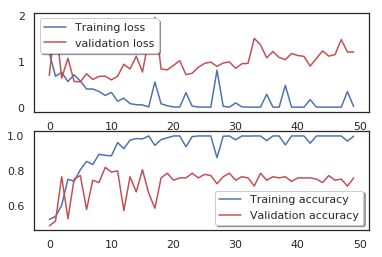

In [28]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

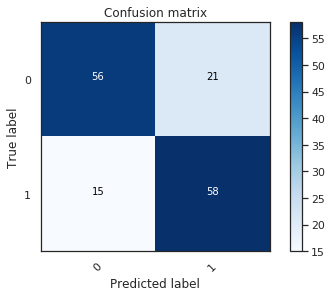

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))